In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
#df=pd.read_csv("/home/aivv/projects/labi_ai/Bank_Stock_Price_10Y.csv")
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NVidia_stock_history.csv")
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1999-01-22,0.401941,0.448595,0.356484,0.376820,271468800.0,0.0,0.0
1,1999-01-25,0.406726,0.421081,0.376820,0.416296,51048000.0,0.0,0.0
2,1999-01-26,0.421081,0.429455,0.378016,0.383998,34320000.0,0.0,0.0
3,1999-01-27,0.385194,0.394764,0.363661,0.382801,24436800.0,0.0,0.0
4,1999-01-28,0.382801,0.385194,0.379212,0.381605,22752000.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5738,2021-11-08,301.489990,311.000000,299.070007,308.040009,50310100.0,0.0,0.0
5739,2021-11-09,322.820007,323.100006,299.640015,306.570007,64674600.0,0.0,0.0
5740,2021-11-10,293.559998,308.500000,287.779999,294.589996,63620600.0,0.0,0.0
5741,2021-11-11,304.679993,305.899994,297.769989,303.899994,33217200.0,0.0,0.0


In [ ]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
df.dropna(inplace=True)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data=[]
  labels=[]
  start_index = start_index + history_size
  if end_index is None:
    end_index=len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size, i)
    data.append(np.reshape(dataset[indices],(history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data),np.array(labels)


array([<Axes: xlabel='Date'>], dtype=object)

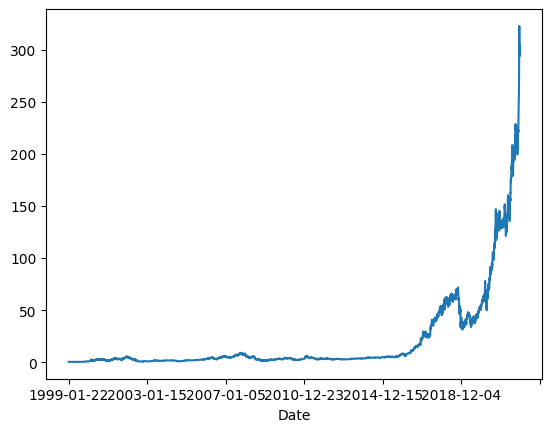

In [ ]:
data = df['Open']
data.index = df['Date']
data.plot(subplots=True)

In [ ]:
TRAIN_SPLIT=1000

train_mean = data[:TRAIN_SPLIT].mean()
train_std = data[:TRAIN_SPLIT].std()
data = (data-train_mean)/train_std

In [ ]:
past_history = 10
future_target = 0

x_train_uni, y_train_uni = univariate_data(data.values.flatten(), 0, TRAIN_SPLIT, past_history, future_target)

x_val_uni, y_val_uni = univariate_data(data.values.flatten(), TRAIN_SPLIT, None, past_history, future_target)

In [ ]:
BATCH_SIZE = 20
BUFFER_SIZE = 1000

train = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val =  tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val = val.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
print(x_train_uni.shape)

(990, 10, 1)


In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 100
EPOCHS = 10

simple_lstm_model.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 4s 15ms/step - loss: 0.6158 - val_loss: 0.2771
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 0.1857 - val_loss: 0.1820
Epoch 3/10
100/100 [==============================] - 1s 9ms/step - loss: 0.1368 - val_loss: 0.1188
Epoch 4/10
100/100 [==============================] - 1s 7ms/step - loss: 0.1050 - val_loss: 0.0800
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0902 - val_loss: 0.0671
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0866 - val_loss: 0.0652
Epoch 7/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0843 - val_loss: 0.0627
Epoch 8/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0832 - val_loss: 0.0592
Epoch 9/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0814 - val_loss: 0.0573
Epoch 10/10
100/100 [==============================] - 1s 6ms/step - loss: 0.0805 - val_loss: 0.055

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

1/1 [==============================] - 0s 400ms/step


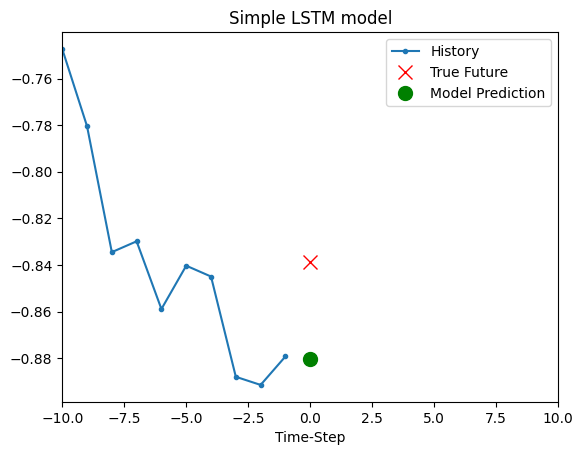

1/1 [==============================] - 0s 21ms/step


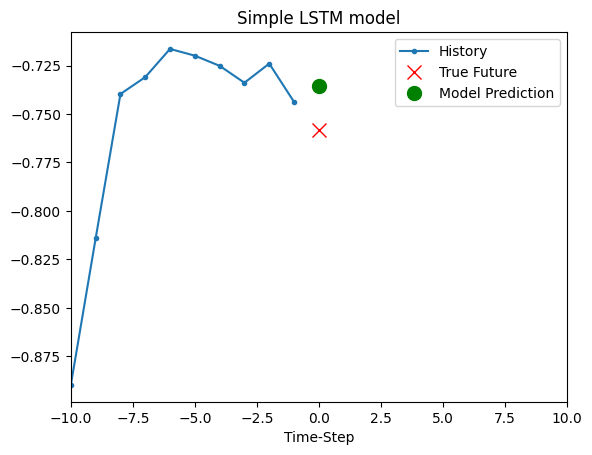

1/1 [==============================] - 0s 21ms/step


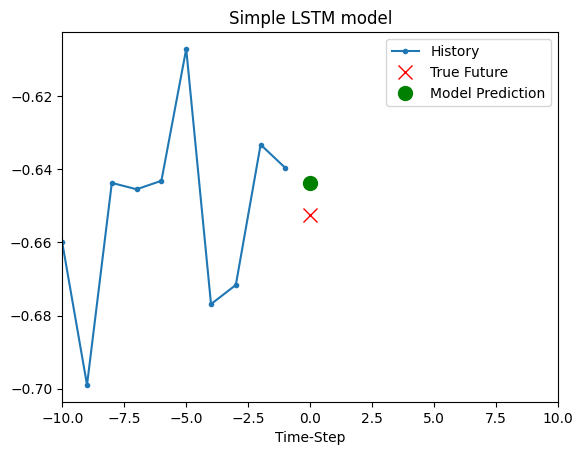

In [ ]:
for x, y in val.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

Прогнозирование на основе многомерного временного ряда

In [ ]:
features_considered = ['Open', 'High', 'Low', 'Close', 'Volume']

In [ ]:
features = df[features_considered]
features.head()

,Open,High,Low,Close,Volume
0,0.401941,0.448595,0.356484,0.376820,271468800.0
1,0.406726,0.421081,0.376820,0.416296,51048000.0
2,0.421081,0.429455,0.378016,0.383998,34320000.0
3,0.385194,0.394764,0.363661,0.382801,24436800.0
4,0.382801,0.385194,0.379212,0.381605,22752000.0


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

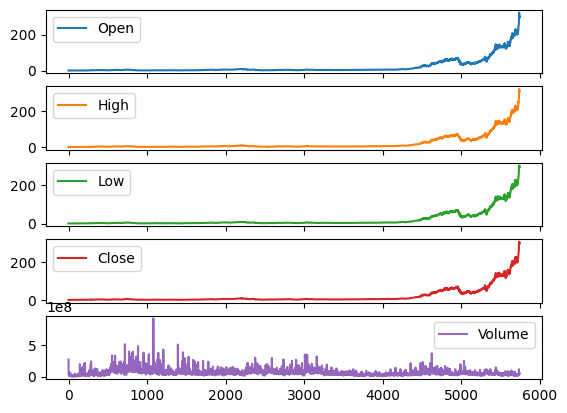

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 600
future_target = 72
STEP = 6
TRAIN_SPLIT = 1000

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print(x_val_single, y_val_single)

[[[-7.47622916e-01 -7.76579637e-01 -7.36132179e-01 -7.70037685e-01
    1.96529348e-01]
  [-8.45397465e-01 -8.74623264e-01 -8.55238324e-01 -8.75298157e-01
    1.84828230e-01]
  [-8.55873378e-01 -8.75756949e-01 -8.36684325e-01 -8.54943670e-01
   -3.67229539e-02]
  ...
  [-1.13251421e-01 -1.36747446e-01 -6.87766865e-02 -9.42744860e-02
   -5.27251248e-02]
  [ 3.14673955e-03 -2.00015664e-02  5.81110673e-02  2.78514413e-02
   -2.17893072e-01]
  [ 1.17216819e-01  6.78395860e-02  1.43698871e-01  9.99628880e-02
   -3.81502123e-01]]

 [[-7.80796412e-01 -8.06049790e-01 -7.94188771e-01 -8.17143295e-01
    1.97359673e+00]
  [-8.88464299e-01 -8.89924731e-01 -8.68405512e-01 -8.84021373e-01
    1.72319491e-01]
  [-8.59365155e-01 -8.88224512e-01 -8.60624909e-01 -8.82276676e-01
   -2.36806436e-01]
  ...
  [-1.11505462e-01 -1.62250052e-01 -1.11272176e-01 -1.47777456e-01
   -6.87085139e-02]
  [ 2.46801565e-02 -1.26352191e-02  6.52926311e-02  3.89000602e-02
   -3.58362834e-01]
  [ 1.14307687e-01  9.8443718

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (100, 5)


In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

1/1 [==============================] - 0s 406ms/step
(20, 1)


In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
100/100 [==============================] - 7s 48ms/step - loss: 0.4897 - val_loss: 1.6873
Epoch 2/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1516 - val_loss: 1.8380
Epoch 3/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1255 - val_loss: 1.8632
Epoch 4/10
100/100 [==============================] - 5s 48ms/step - loss: 0.1191 - val_loss: 1.7767
Epoch 5/10
100/100 [==============================] - 4s 38ms/step - loss: 0.1160 - val_loss: 1.7740
Epoch 6/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1110 - val_loss: 1.8133
Epoch 7/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1070 - val_loss: 1.8137
Epoch 8/10
100/100 [==============================] - 5s 49ms/step - loss: 0.1049 - val_loss: 1.9445
Epoch 9/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1045 - val_loss: 1.8627
Epoch 10/10
100/100 [==============================] - 3s 34ms/step - loss: 0.0998 - val_lo

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

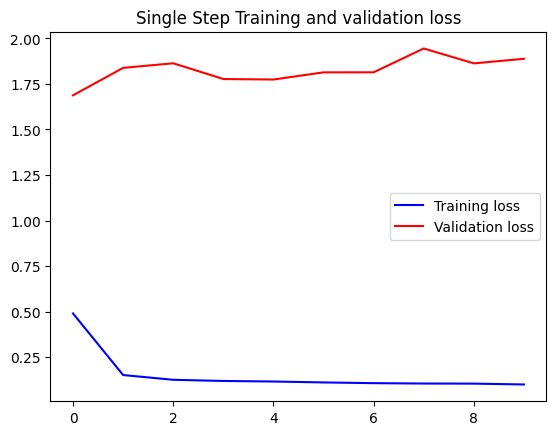

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

1/1 [==============================] - 0s 34ms/step


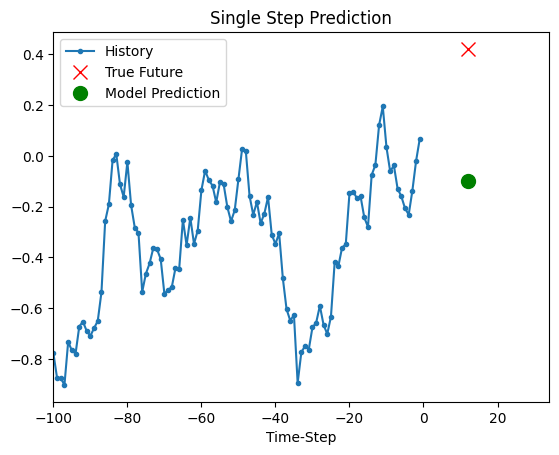

1/1 [==============================] - 0s 32ms/step


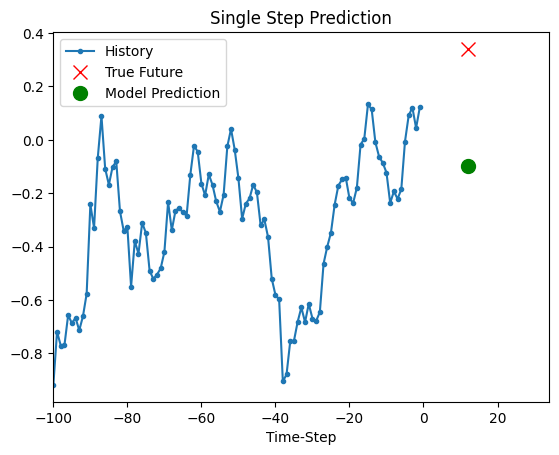

1/1 [==============================] - 0s 29ms/step


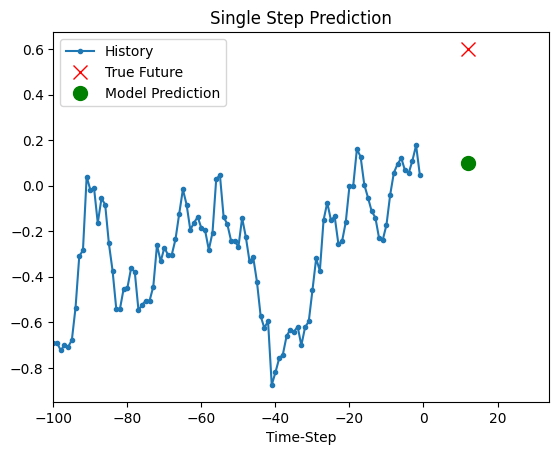

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Интервальное прогнозирование

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (100, 5)

 Target temperature to predict : (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

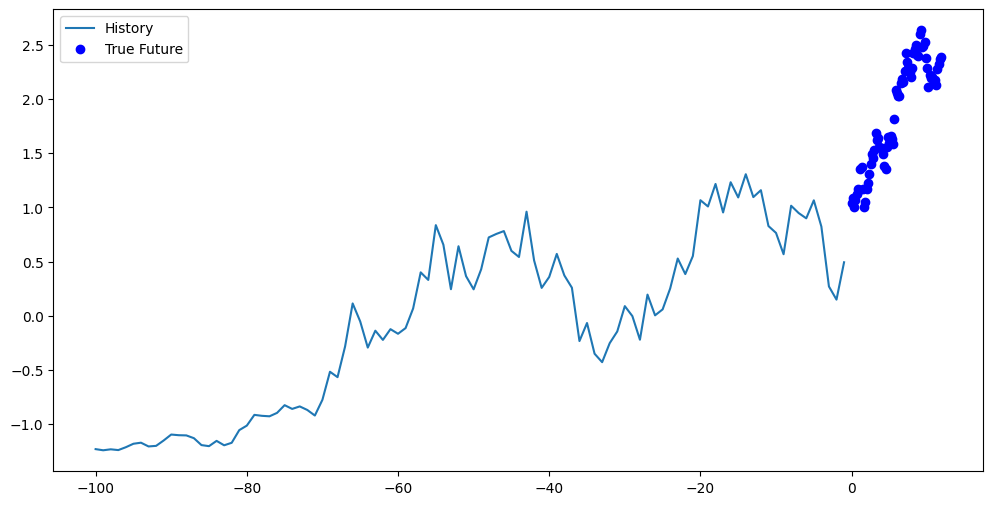

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

1/1 [==============================] - 1s 595ms/step
(20, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
100/100 [==============================] - 12s 78ms/step - loss: 0.7222 - val_loss: 1.2435
Epoch 2/10
100/100 [==============================] - 9s 91ms/step - loss: 0.3033 - val_loss: 1.2847
Epoch 3/10
100/100 [==============================] - 7s 73ms/step - loss: 0.2242 - val_loss: 1.3048
Epoch 4/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2015 - val_loss: 1.3051
Epoch 5/10
100/100 [==============================] - 8s 80ms/step - loss: 0.1877 - val_loss: 1.2914
Epoch 6/10
100/100 [==============================] - 8s 81ms/step - loss: 0.1736 - val_loss: 1.2276
Epoch 7/10
100/100 [==============================] - 9s 88ms/step - loss: 0.1619 - val_loss: 1.2086
Epoch 8/10
100/100 [==============================] - 7s 72ms/step - loss: 0.1538 - val_loss: 1.1785
Epoch 9/10
100/100 [==============================] - 9s 90ms/step - loss: 0.1499 - val_loss: 1.1837
Epoch 10/10
100/100 [==============================] - 8s 75ms/step - loss: 0.1448 - val_l

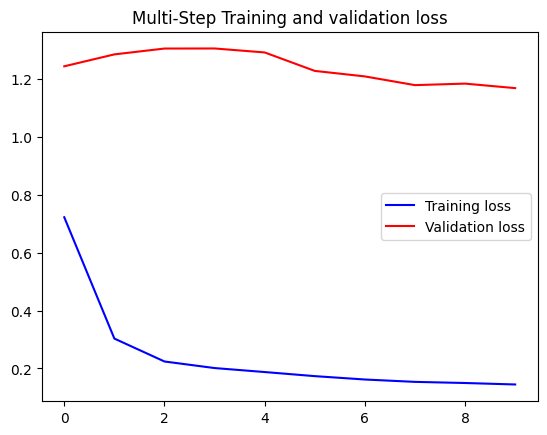

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

1/1 [==============================] - 0s 34ms/step


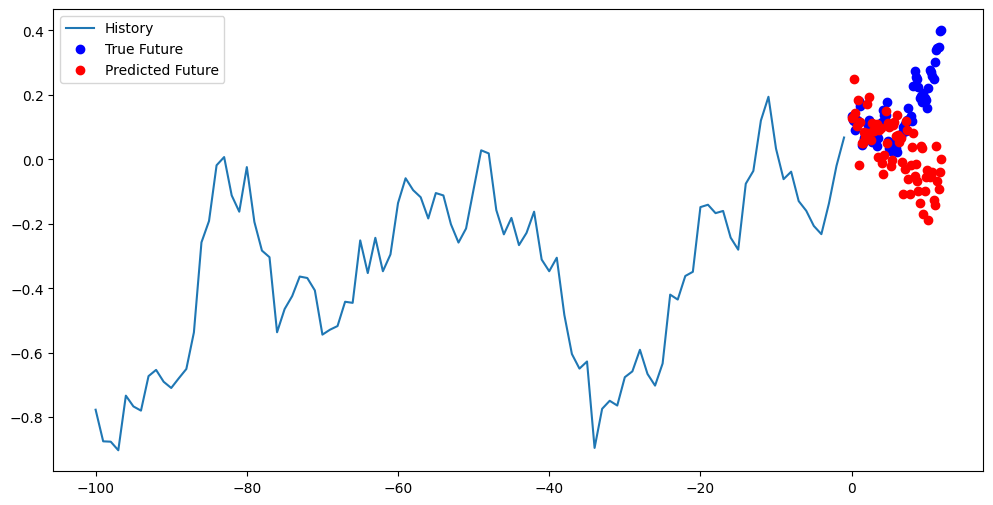

1/1 [==============================] - 0s 35ms/step


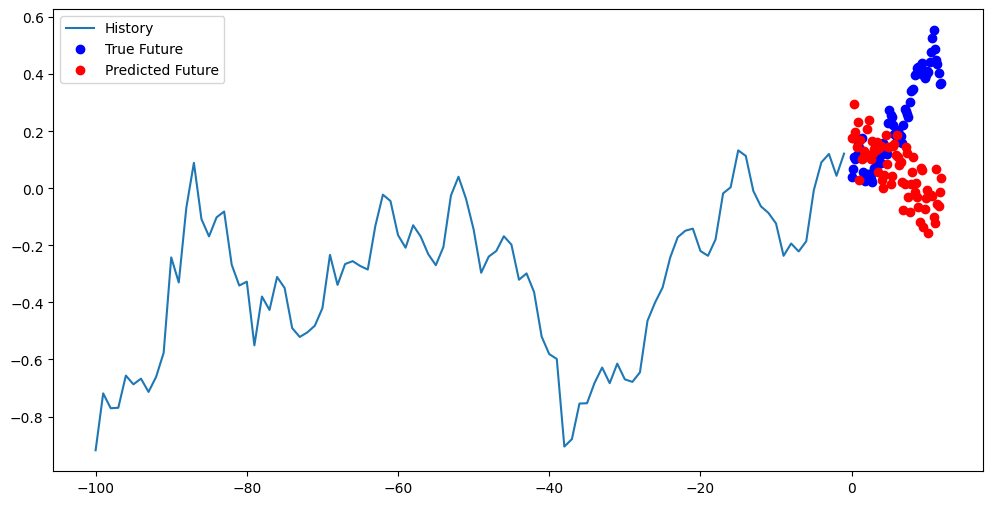

1/1 [==============================] - 0s 31ms/step


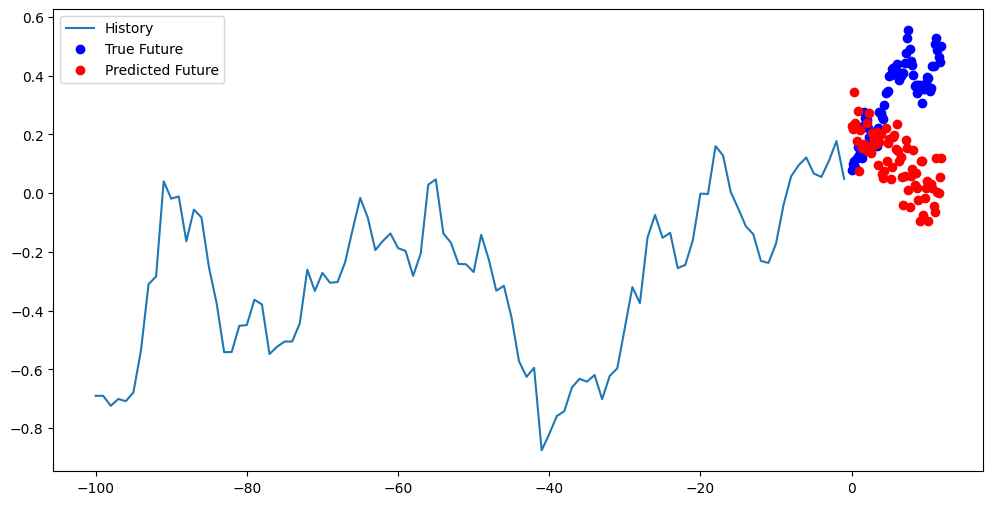

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

1/1 [==============================] - 1s 556ms/step
(20, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
100/100 [==============================] - 12s 78ms/step - loss: 0.7369 - val_loss: 1.2631
Epoch 2/10
100/100 [==============================] - 9s 86ms/step - loss: 0.2658 - val_loss: 1.3010
Epoch 3/10
100/100 [==============================] - 7s 67ms/step - loss: 0.1881 - val_loss: 1.2911
Epoch 4/10
100/100 [==============================] - 9s 87ms/step - loss: 0.1588 - val_loss: 1.3837
Epoch 5/10
100/100 [==============================] - 7s 67ms/step - loss: 0.1505 - val_loss: 1.5269
Epoch 6/10
100/100 [==============================] - 9s 87ms/step - loss: 0.1453 - val_loss: 1.4361
Epoch 7/10
100/100 [==============================] - 7s 68ms/step - loss: 0.1404 - val_loss: 1.4002
Epoch 8/10
100/100 [==============================] - 9s 90ms/step - loss: 0.1363 - val_loss: 1.4639
Epoch 9/10
100/100 [==============================] - 7s 67ms/step - loss: 0.1326 - val_loss: 1.4733
Epoch 10/10
100/100 [==============================] - 9s 88ms/step - loss: 0.1302 - val_l

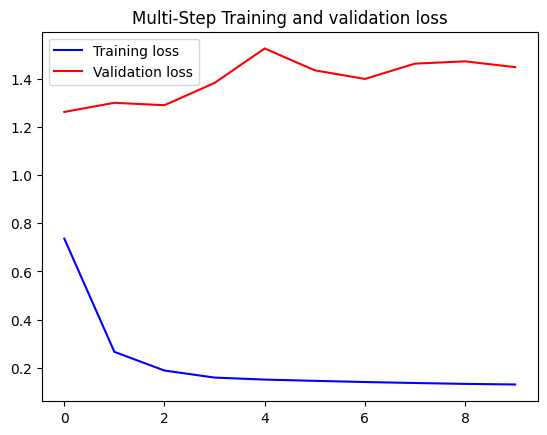

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

1/1 [==============================] - 0s 32ms/step


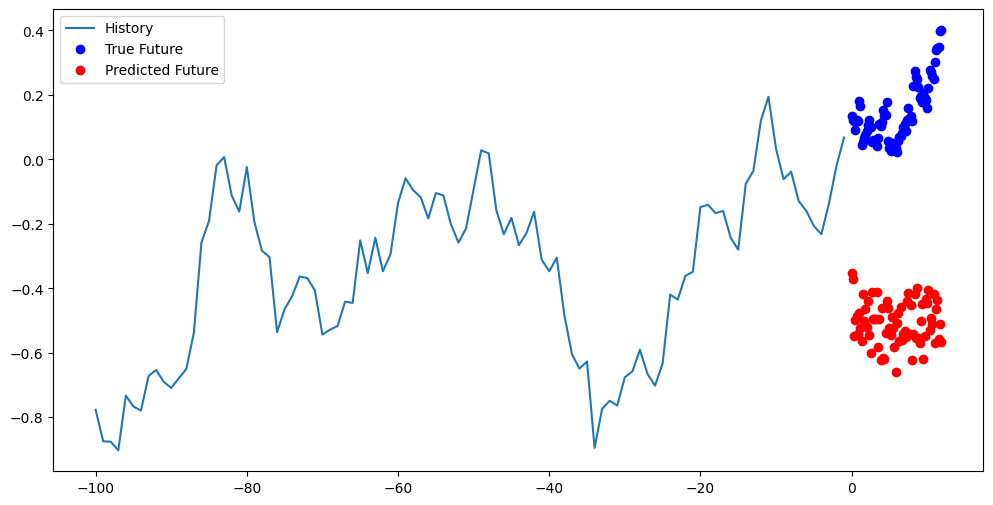

1/1 [==============================] - 0s 32ms/step


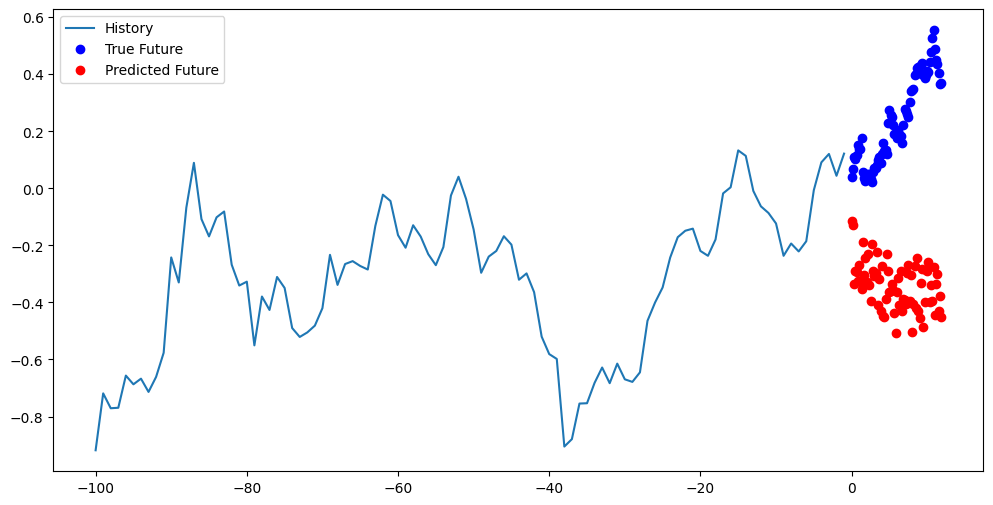

1/1 [==============================] - 0s 32ms/step


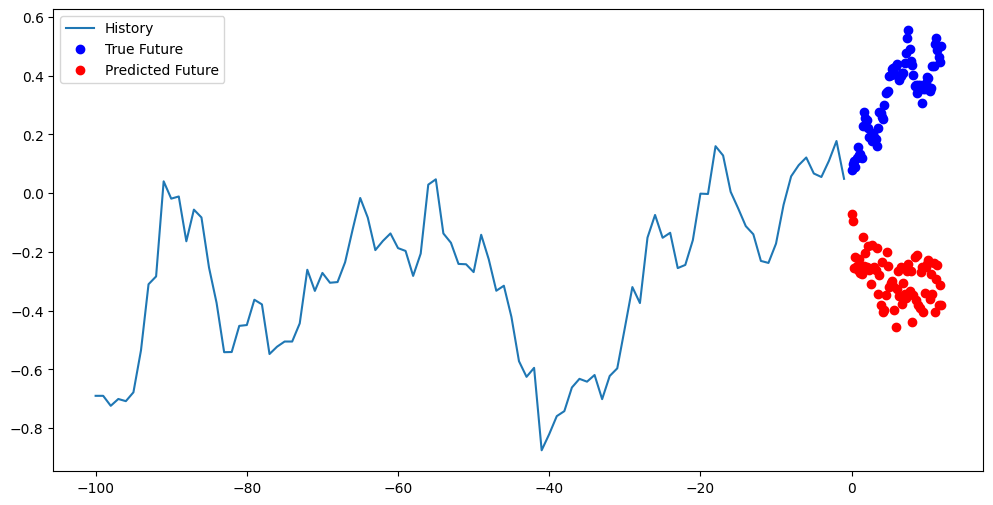

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

1) Для решения каких задач применяются рекуррентные нейронные сети?

Рекуррентные нейронные сети широко применяются для задач, связанных с последовательными данными, такими как:

Обработка естественного языка (машинный перевод, генерация текста)
Анализ временных рядов и прогнозирование (прогнозирование продаж, финансовых временных рядов и т.д.)
Распознавание речи
Генерация и обработка музыки/аудио
И других задач, где входные данные представляют собой последовательность.

2) Чем структурные/перекрестные данные отличаются от временных рядов?

Структурные/перекрестные данные отличаются от временных рядов тем, что они не имеют четкого порядка, как элементы последовательности во временном ряду. Примеры структурных данных - таблицы в базах данных, графы социальных сетей и т.п.

3) В чем отличие «интервальной модели» прогнозирования от точечной модели?

Интервальное прогнозирование в отличие от точечного дает диапазон возможных значений для прогноза с определенной вероятностью попадания истинного значения в этот интервал. Точечное прогнозирование предсказывает лишь одно конкретное значение на будущее. Интервальные модели более информативны, но и более сложны в построении.

4) Какие инструменты, позволяющие измерить, насколько хорошо модель предсказывает результаты на основе имеющихся данных, Вы знаете?

Для оценки качества прогнозов модели на основе имеющихся данных обычно используются такие метрики, как среднеквадратичная ошибка (MSE), средняя абсолютная ошибка (MAE), коэффициент детерминации (R^2) и другие в зависимости от типа задачи. Также строят графики реальных и предсказанных значений для визуальной оценки.

5) Поясните, суть проблемы с исчезающими и расширяющимися градиентами в глубоком обучении.

Проблема исчезающих/расширяющихся градиентов связана с тем, что в процессе обратного распространения ошибки сквозь многослойную нейронную сеть, градиенты могут экспоненциально уменьшаться (исчезать) или увеличиваться (расширяться) на каждом слое. Это мешает эффективному обучению.

6) Как на практике решают проблему исчезновения и взрывного роста градиентов?

Для решения проблемы градиентов используются специальные методы инициализации весов, применение функций активации, не насыщающихся в областях больших/малых значений (ReLU, ELU и др.), пакетная нормализация, архитектуры с остаточными связями и обходными каналами (ResNet), а также алгоритмы оптимизации, устойчивые к этой проблеме (RMSProp, Adam).

7) Какие реализации рекуррентных слоев представлены в библиотеке Keras? В чем их отличие?

В библиотеке Keras есть разные реализации рекуррентных слоев - SimpleRNN, LSTM, GRU. Они отличаются внутренней архитектурой ячеек памяти. LSTM и GRU лучше справляются с проблемой исчезающего градиента за счет дополнительных гейтов, управляющих потоками информации. Слой SimpleRNN наиболее простой, но менее эффективен для задач с длинными зависимостями.

Вывод:
По результатам обучения и проверки двух моделей можно заметить, что первая модель с функцией активации "swish" и оптимизатором RMSprop достигла меньшей средней абсолютной ошибки (MAE) по сравнению со второй моделью с функцией активации "relu" и оптимизатором Adam. Первая модель последовательно уменьшала свои потери на протяжении всех эпох, что свидетельствует о лучшей эффективности прогнозирования целевых значений. С другой стороны, вторая модель демонстрировала колебания значений потерь во время обучения, что может свидетельствовать о менее стабильной работе. Таким образом, для данного конкретного набора данных и задачи первая модель оказалась более эффективной с точки зрения минимизации ошибок предсказания.